In [1]:
!date

Wed Feb 12 09:51:40 PST 2020


# Standard cell type annotation

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from scipy import stats
from scipy.optimize import curve_fit
from functools import reduce
from sklearn.metrics import adjusted_rand_score
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [3]:
gene = anndata.read_h5ad("cell_ranger_annotation/gene.h5ad")
isoform = anndata.read_h5ad("cell_ranger_annotation/isoform.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
print(gene)
print(isoform)

AnnData object with n_obs × n_vars = 6043 × 20586 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_TPM', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'gene_id', 'gene_name', 'txn_list', 'num_isoforms', 'gene_TPM', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p'
AnnData object with n_obs × n_vars = 6043 × 84364 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_TPM', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'gene_TPM', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pc

# Summary statistics

To do so we need to first pick a subset of genes on which to cluster

We define the highly variable genes for which the dispersion of that gene is hgih. 
TODO: Compare to clustering on all genes

In [5]:
mtx = gene.layers["X"]

In [6]:
mean = np.asarray(mtx.mean(axis=0)).reshape(-1)
var = np.asarray(mtx.power(2).mean(axis=0)).reshape(-1) - mean**2

In [7]:
dispersion = var / mean

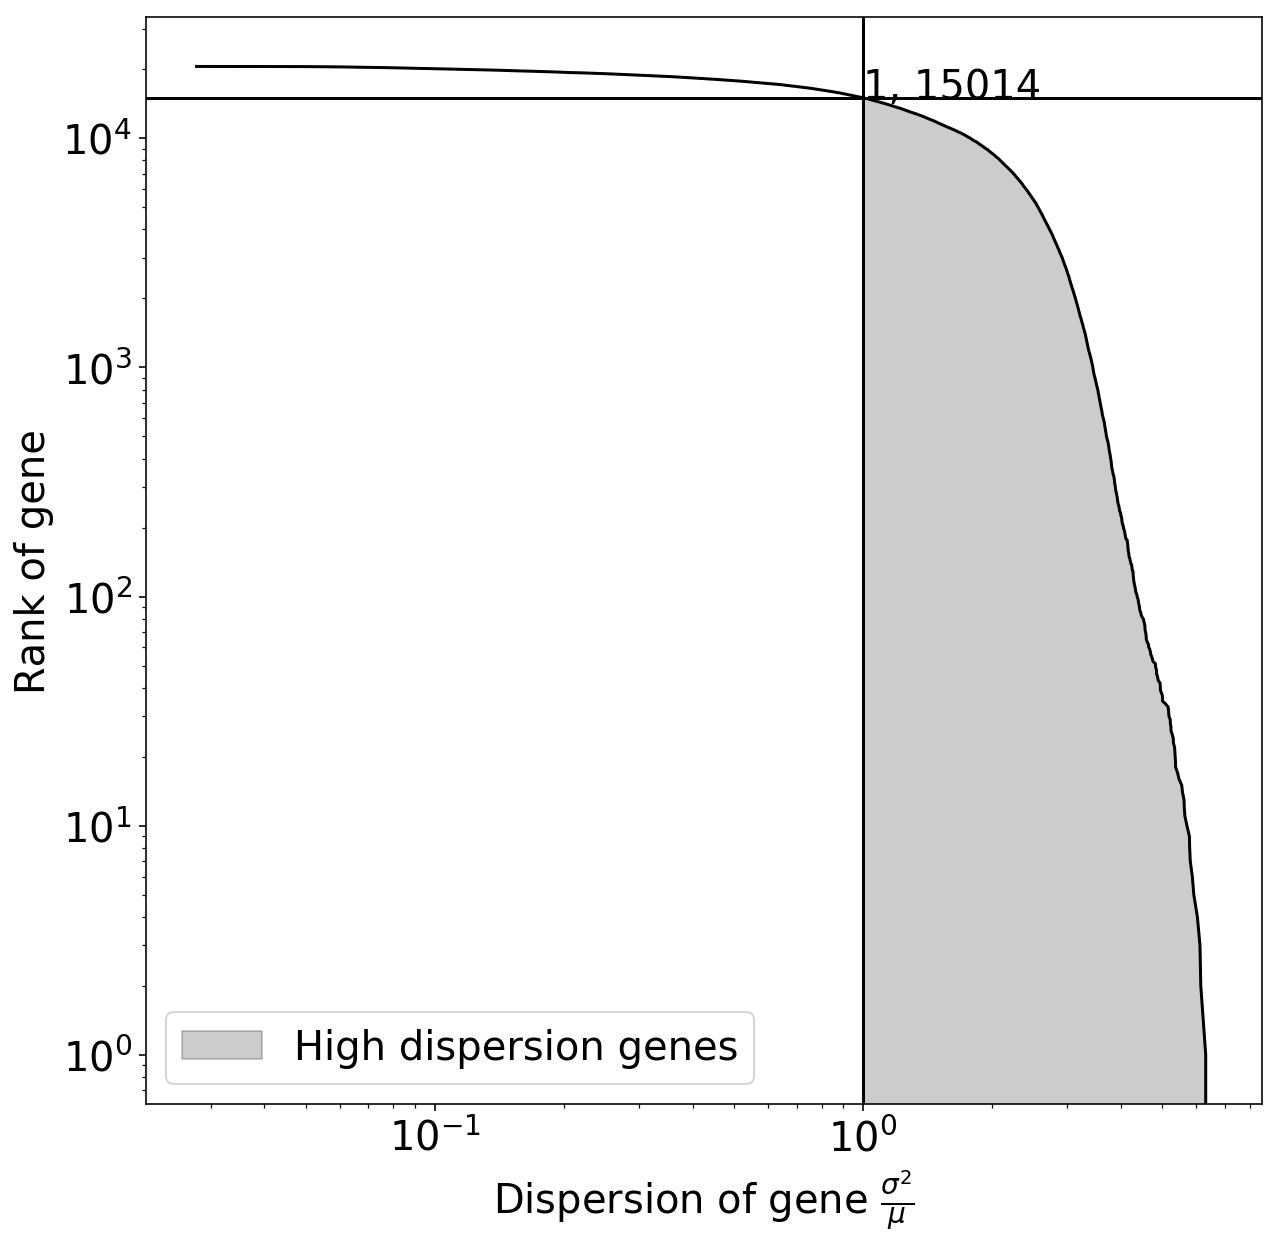

In [11]:
fig, ax = plt.subplots(figsize=(10,10))

disp_threshold = 1

x = np.sort(dispersion)[::-1]
y = np.arange(dispersion.shape[0])

ax.loglog(x, y, color="k")
ax.set_xlabel("Dispersion of gene " +  r"$\frac{\sigma^2}{\mu}$")
ax.set_ylabel("Rank of gene")

idx = np.where(x<disp_threshold)[0][0]
line = y[idx]

ax.text(disp_threshold, line, "{}, {}".format(disp_threshold, line))

ax.axvline(disp_threshold, color="k")
ax.axhline(line, color="k")
#ax.fill_between(np.arange(min(x),disp_threshold),0,line, alpha=0.2, color="k")
ax.fill_between(x[:idx],y[:idx], alpha=0.2, color="k", label="High dispersion genes")
#ax.fill_between(x[:idx],y[:idx], alpha=0.2, color="k", label="High dispersion genes")

ax.legend()

plt.show()

In [12]:
mask = dispersion > disp_threshold

mean_filt = mean[mask]
var_filt = var[mask]

In [13]:
def f(mu, phi):
    return mu + phi*mu**2

In [14]:
popt, pcov = curve_fit(f, mean, var)

In [15]:
phi = popt[0]
perr = np.sqrt(pcov[0][0]) # one standard deviation errors on parameter phi. pcov is the estimated covariance of popt. 

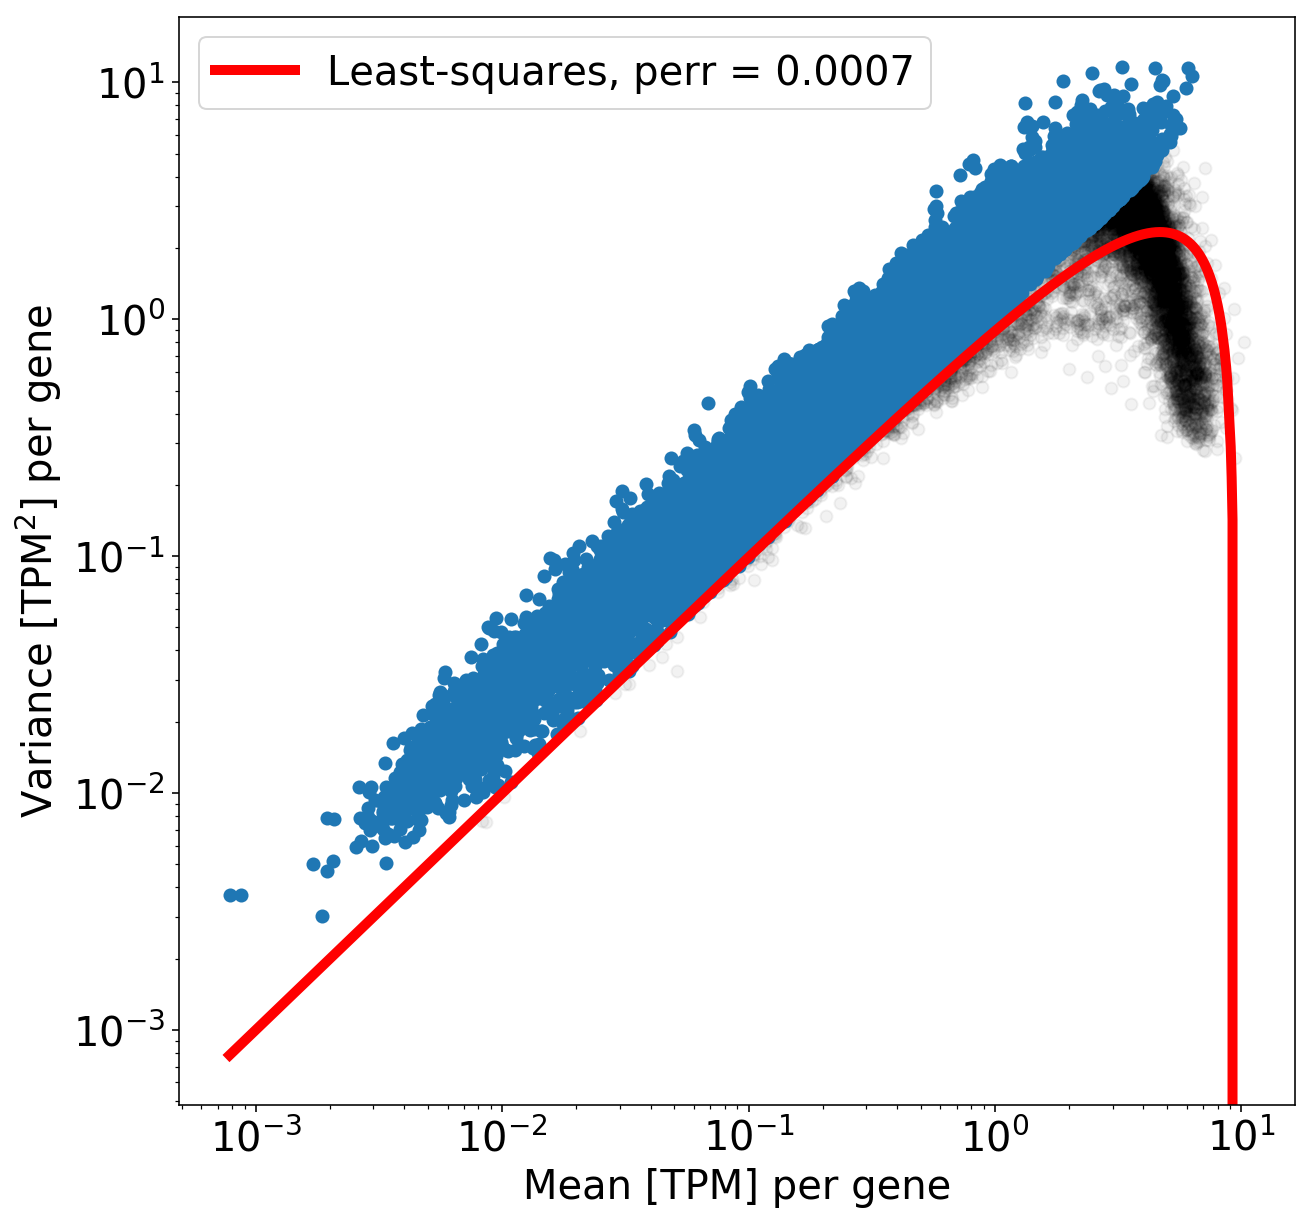

In [16]:
fig, ax = plt.subplots(figsize=(10,10))

x = mean
y = var

ax.scatter(x, y, color="k", alpha=0.05)

xx = np.unique(mean)
yy = f(xx, phi)

ax.plot(xx, yy, color="r", linewidth=5, label="Least-squares, perr = {:,.4f}".format(perr))


xxx = mean_filt
yyy = var_filt
ax.scatter(xxx, yyy)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("Mean [TPM] per gene")
ax.set_ylabel("Variance [TPM$^2$] per gene")

ax.legend()

plt.show()

## The knee plot

In [17]:
mtx = gene.layers["X"]

In [18]:
tpm = np.asarray(mtx.sum(axis=1)).reshape(-1)

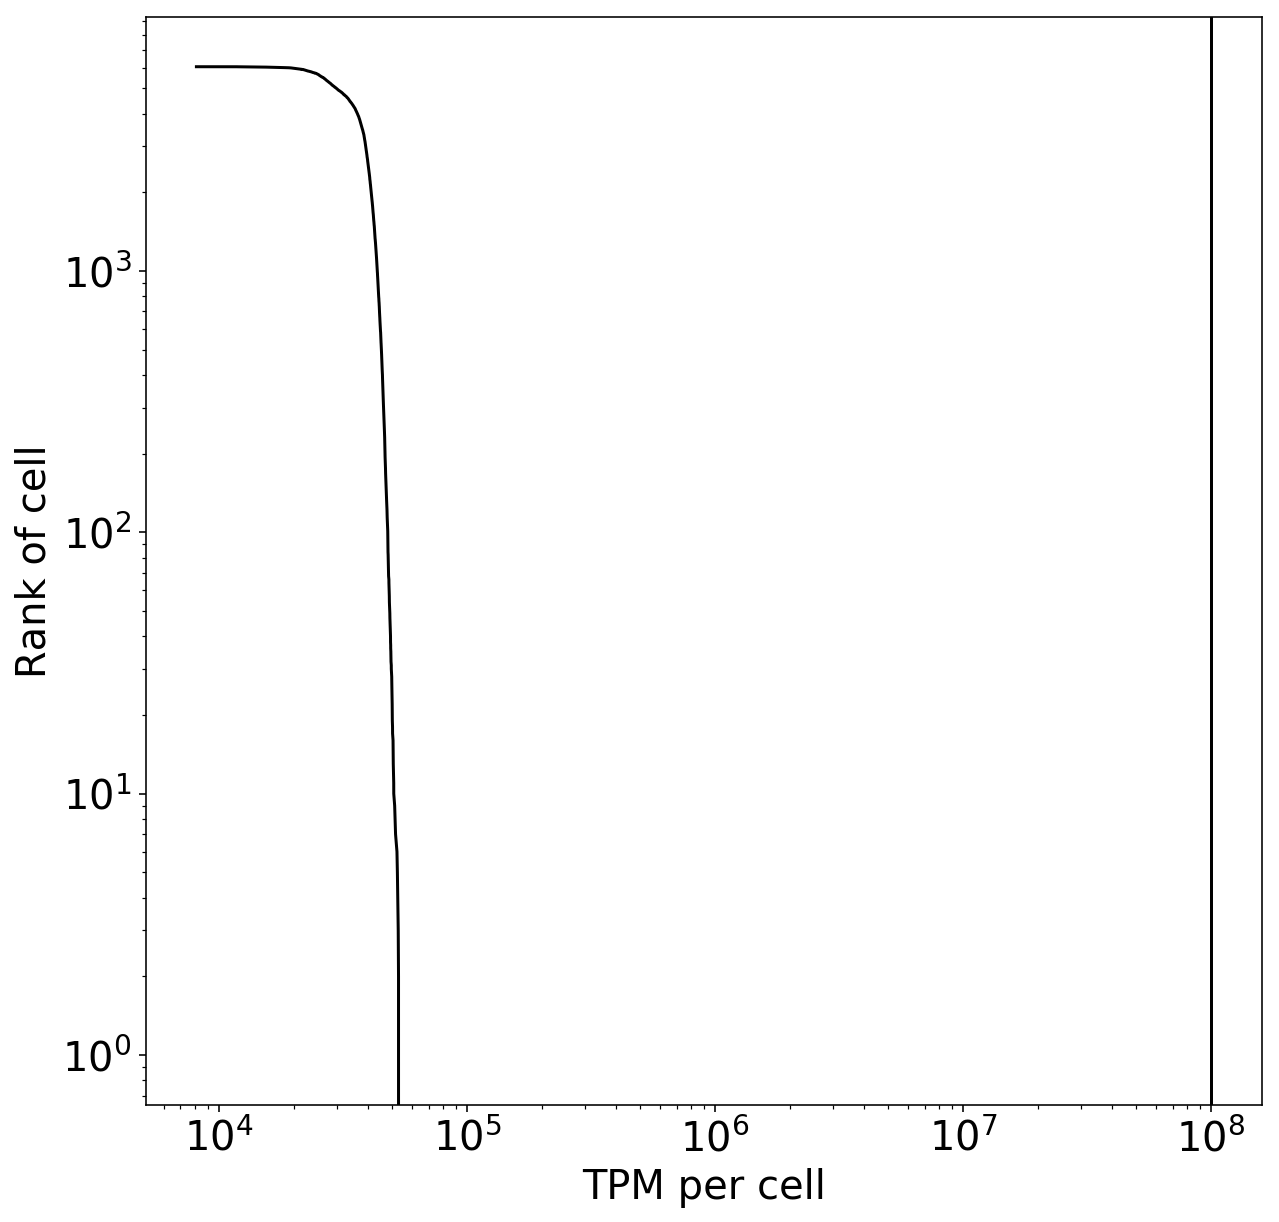

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

cell_threshold = 100e6

x = np.sort(tpm)[::-1]
y = np.arange(tpm.shape[0])

ax.loglog(x, y, color="k")
ax.set_xlabel("TPM per cell")
ax.set_ylabel("Rank of cell")

line = y[np.where(x<cell_threshold)[0][0]]

#ax.text(cell_threshold, line, "{:,.0f}, {:,}".format(cell_threshold, line))
#
ax.axvline(cell_threshold, color="k")
ax.axhline(line, color="k")
#ax.fill_between(np.arange(min(x), cell_threshold),0,line, alpha=0.2, color="k")

plt.show()

## Saturation curve: Genes detected per cell

In [24]:
mtx = gene.layers["log1p"] # looks much better on log data

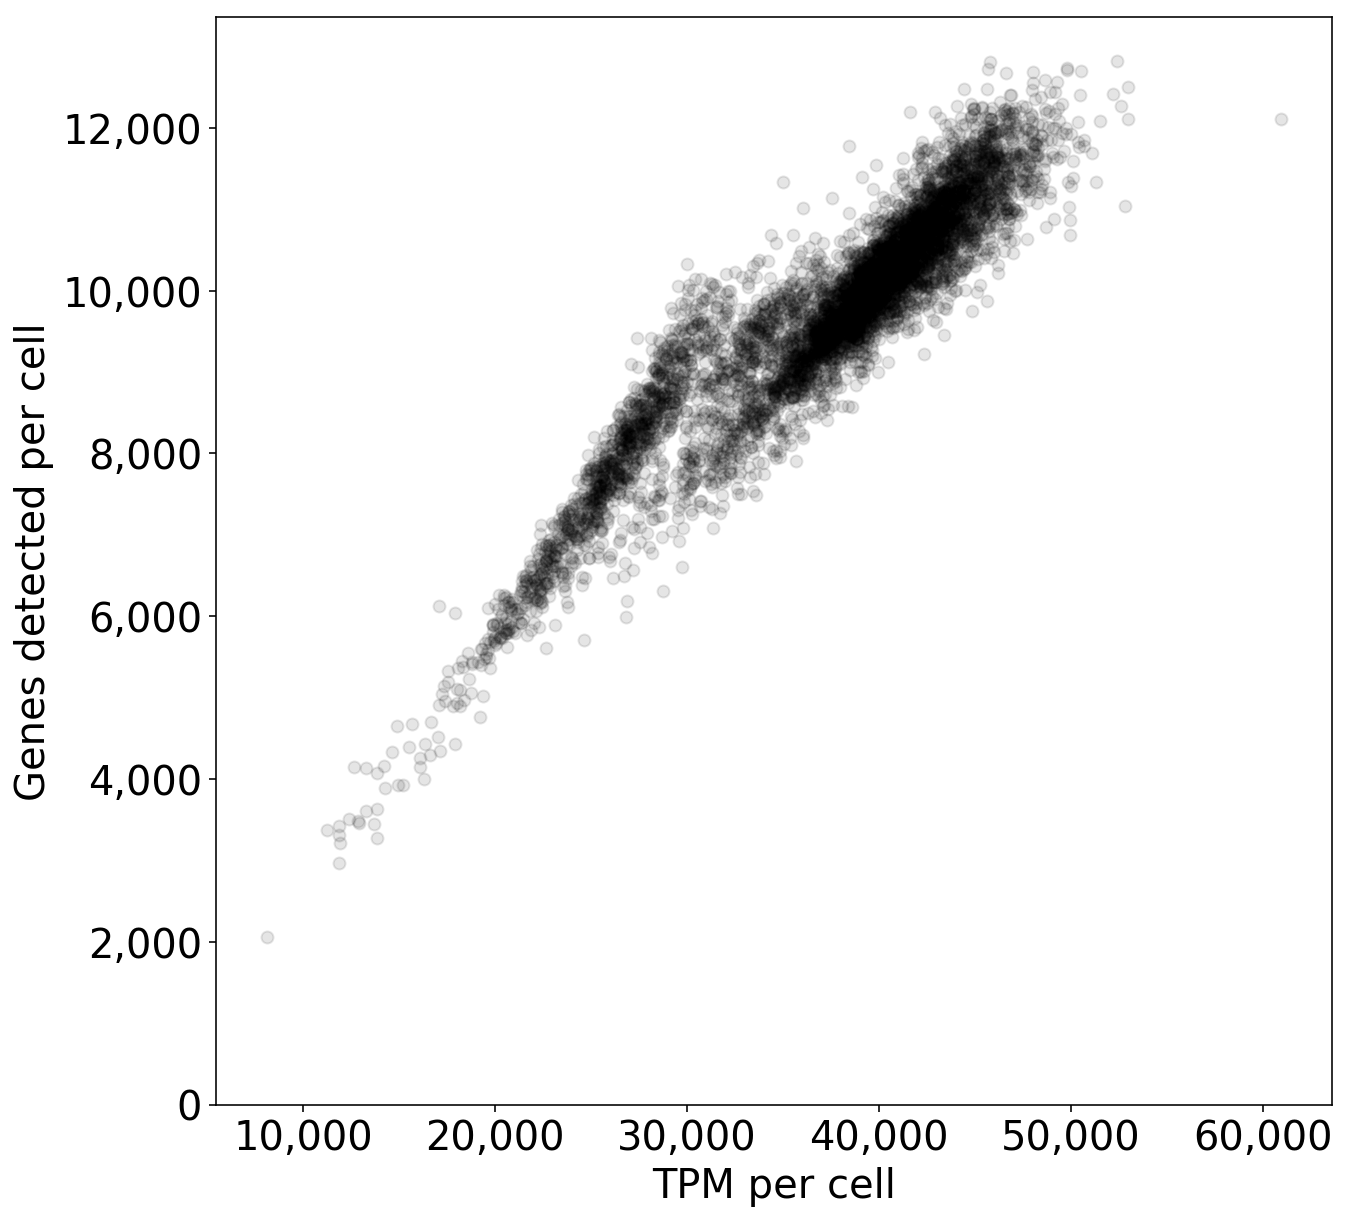

In [25]:
fig, ax = plt.subplots(figsize=(10,10))

x = np.asarray(mtx.sum(axis=1)).reshape(-1)
y = np.asarray((mtx > 0).sum(axis=1)).reshape(-1)

ax.scatter(x, y, color="k", alpha=0.1)

#ax.set_xscale("log") # if you use log1p comment this out
ax.set_ylim(0)
ax.set_xlabel("TPM per cell")
ax.set_ylabel("Genes detected per cell")
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

In [26]:
np.median(y)

9893.0

## Number of cells in each gene

In [27]:
mtx = gene.layers["X"]

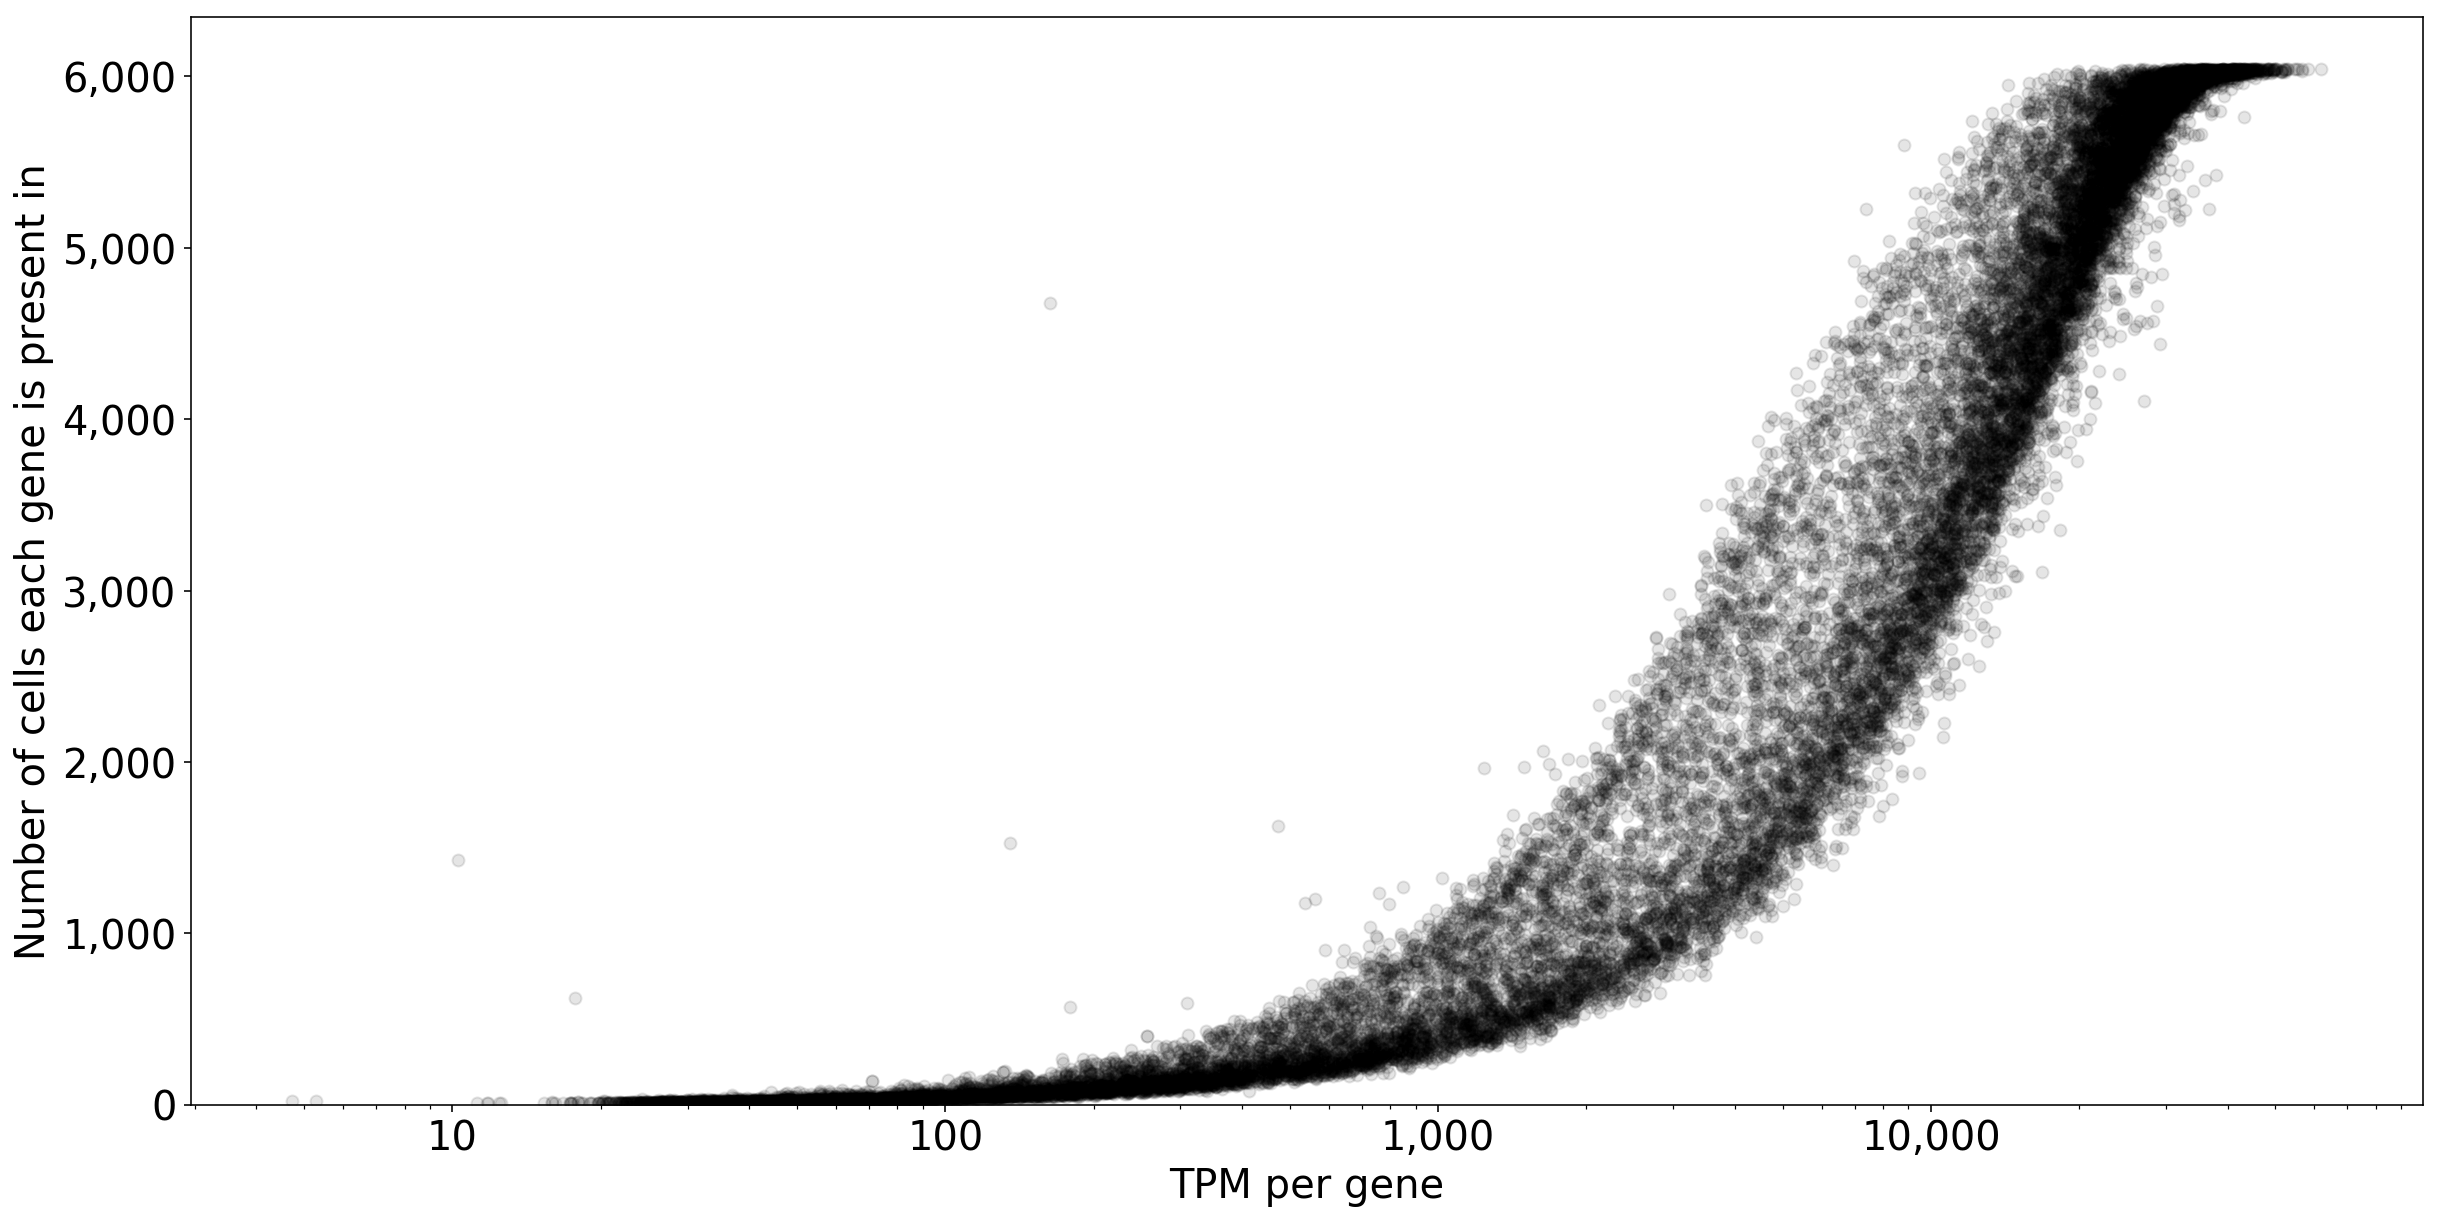

In [28]:
fig, ax = plt.subplots(figsize=(20,10))

x = np.asarray(mtx.sum(axis=0)).reshape(-1)
y = np.asarray((mtx > 0).sum(axis=0)).reshape(-1)

ax.scatter(x, y, color="k", alpha=0.1)
ax.set_xscale('log')

ax.set_ylim(0)
ax.set_xlabel("TPM per gene")
ax.set_ylabel("Number of cells each gene is present in")
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

## Does PC1 correlate with saturation per cell (# of genes per cell)

In [29]:
mtx = gene.layers["X"]
pc1 = gene.obsm["X_pca"][:,0]

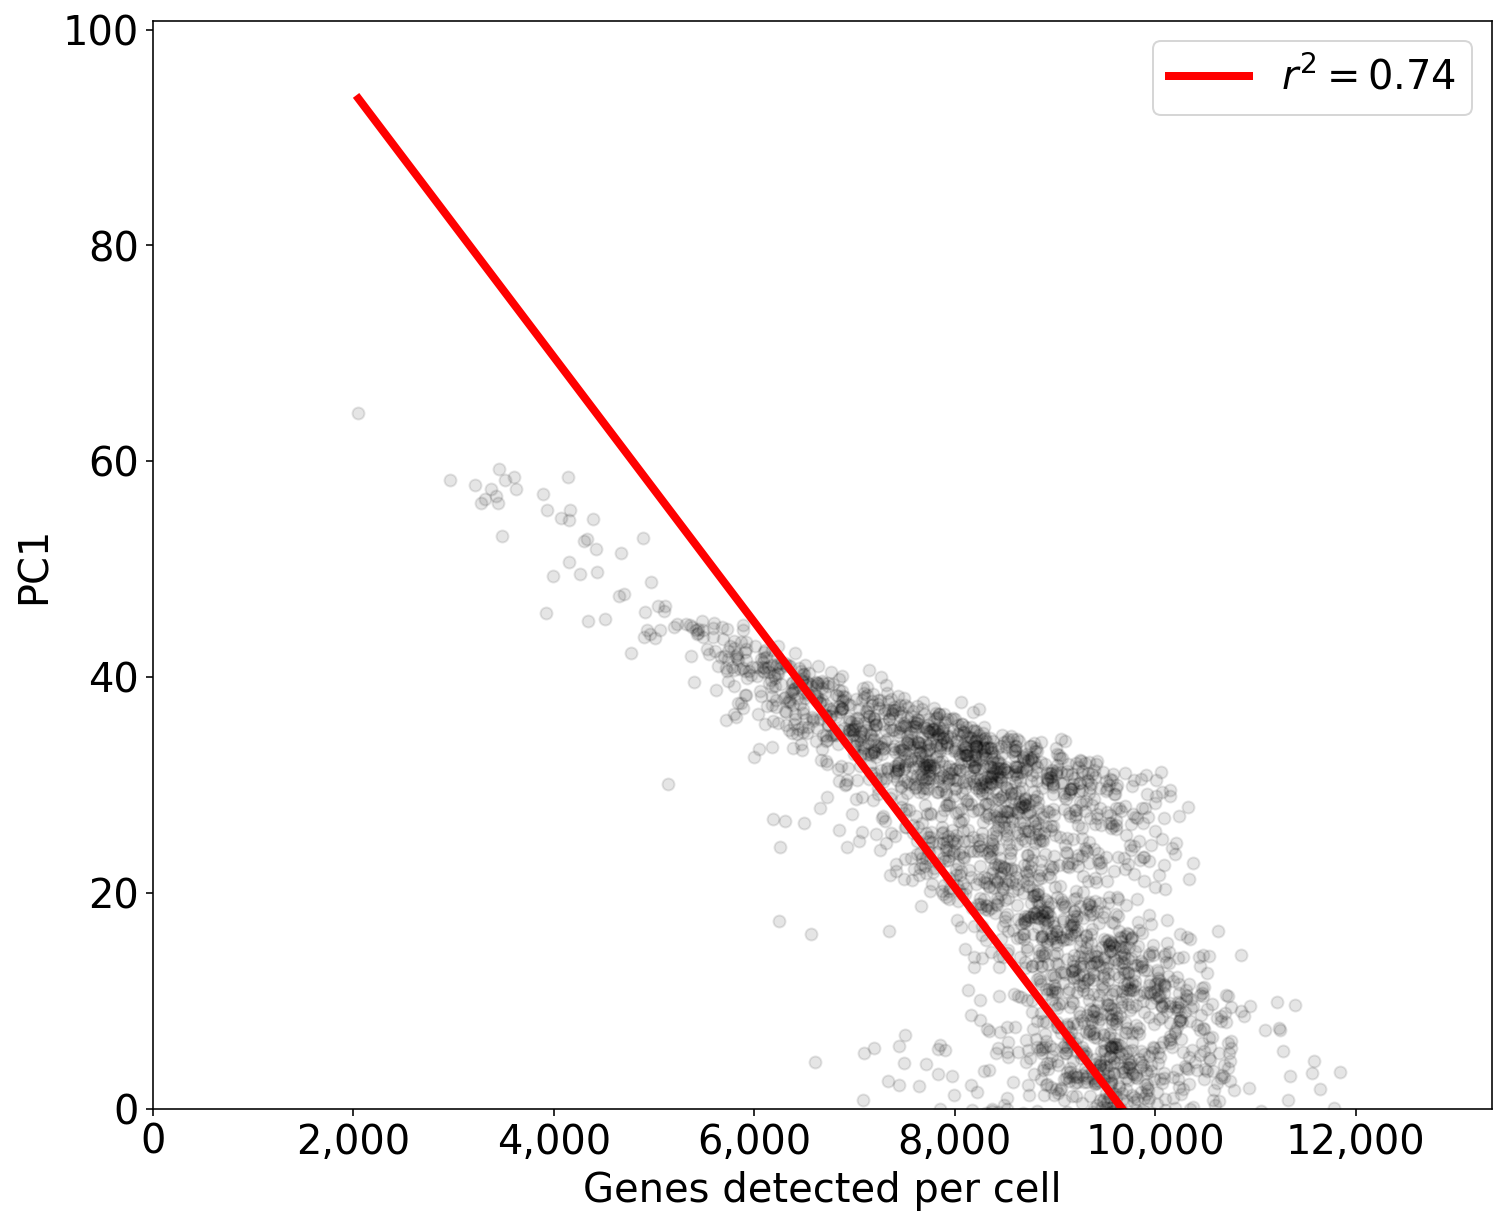

In [30]:
fig, ax = plt.subplots(figsize=(12,10))

x = np.asarray((mtx>0).sum(axis=1)).reshape(-1)
y = np.asarray(pc1).reshape(-1)

gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
mn=np.min(x); mx=np.max(x); xx=np.linspace(mn,mx,500); yy=gradient*xx+intercept

ax.scatter(x, y, color='k', alpha=0.1)
ax.plot(xx, yy, color='r', linewidth=4, label="$r^2=${:,.2f}".format(r_value**2))

ax.set_xlabel("Genes detected per cell")
ax.set_ylabel("PC1")
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_xlim(0)
ax.set_ylim(0)

ax.legend()

plt.show()


## Fraction of genes with zeros

In [31]:
mtx = gene.layers["X"]

In [32]:
frac_zeros =  np.asarray((mtx == 0).sum(axis=0)).reshape(-1)/mtx.shape[1]
mean = np.asarray(mtx.mean(axis=0)).reshape(-1)
p = (phi**-1/(mean + phi**-1))**(phi**-1)

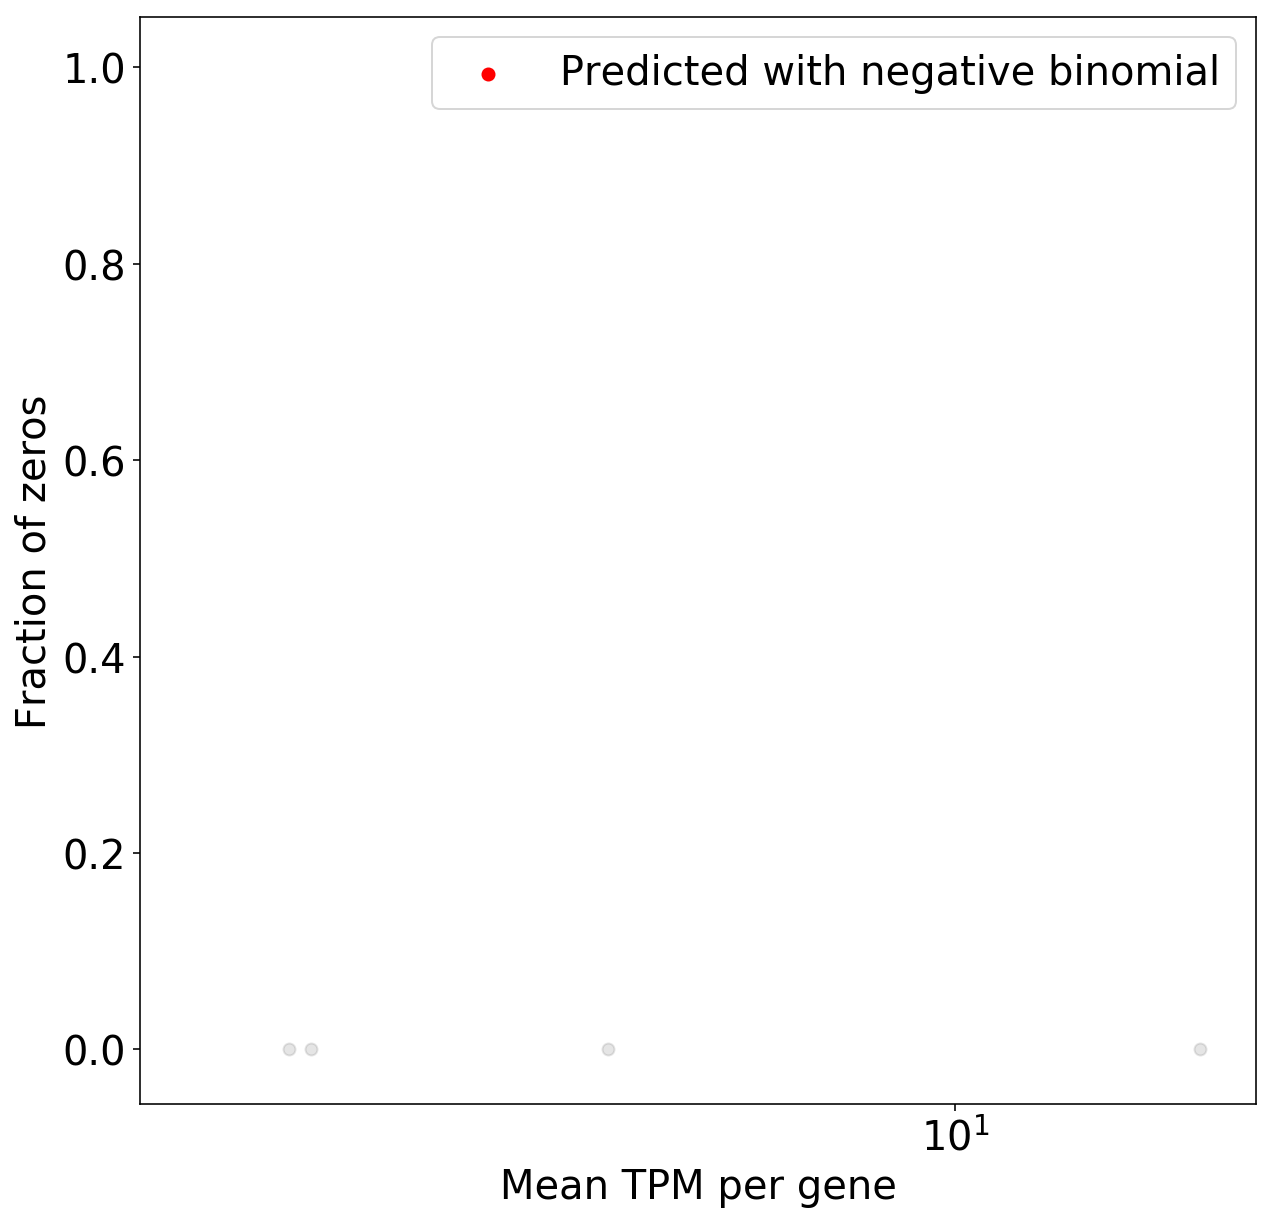

In [33]:
fig, ax = plt.subplots(figsize=(10,10))

x = mean
y = frac_zeros

ax.scatter(x, y, color="k", alpha=0.1)

xx = mean
yy = p

ax.scatter(xx, yy, color='r', label="Predicted with negative binomial")

ax.set_xscale('log')
ax.set_xlabel("Mean TPM per gene")
ax.set_ylabel("Fraction of zeros")

ax.legend()

plt.show()

# Clustering

In [111]:
random_state = 42
n_clusters = 3
n_iter = 300
tol = 0.0001
n_jobs = 40

In [112]:
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, max_iter=n_iter, tol=tol, verbose=True, n_jobs=n_jobs)

### Kmeans on all of the raw count data

In [113]:
kmeans.fit(gene.obsm["X_pca"])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=40, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=True)

In [114]:
gene.obs["kmeans_3"] = kmeans.labels_

In [94]:
%%time
kmeans.fit(gene.layers["log1p"])

CPU times: user 798 ms, sys: 353 ms, total: 1.15 s
Wall time: 1h 59min 37s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=40, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=True)

# Using louvain and leiden, lets assign top genes with scanp

In [150]:
gene.var = gene.var.set_index("gene_name")

In [487]:
corr_method = "benjamini-hochberg"
test_method = 't-test'
group = "leiden"
layer="log1p"
n_genes =128
clusters = gene.obs.leiden.unique()

In [488]:
%%time
scanp.tl.rank_genes_groups(gene, use_raw=False, 
                           layer=layer, 
                           groupby=group, 
                           method=test_method, 
                           n_genes = n_genes, 
                           corr_method=corr_method)

CPU times: user 6.79 s, sys: 1.95 s, total: 8.74 s
Wall time: 8.74 s


In [489]:
gene

AnnData object with n_obs × n_vars = 6067 × 20586 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'cell_TPM', 'pass_count_filter', 'leiden', 'louvain', 'kmeans_4', 'kmeans_3', 'sina_class_label'
    var: 'gene_id', 'txn_list', 'num_isoforms', 'gene_TPM', 'dispersion', 'pass_disp_filter'
    uns: 'leiden', 'louvain', 'neighbors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne'
    layers: 'X', 'log1p'

In [490]:
gene.uns["rank_genes_groups"]["names"][3]

('Trbc2', 'S100a10', 'Rtn4r', 'Dgkb', 'Igfbp6', 'Gad1', 'Nrn1', 'Ap1s2', 'Igf1', 'Tle4', 'Nxph3', 'Dner', 'Nrsn2', 'Gad2', 'Rprm', 'Sst', 'Dner', 'Cox6a2', 'Arpp21', 'Sparc')

In [491]:
GABA = pd.Series(gene.obs.groupby("class_label")["cluster_label"].apply(list)["GABAergic"]).apply(lambda x: x.split(" ")[-1].split("_")[0]).unique()
Glut = pd.Series(gene.obs.groupby("class_label")["cluster_label"].apply(list)["Glutamatergic"]).apply(lambda x: x.split(" ")[-1].split("_")[0]).unique()
LOWQ = pd.Series(gene.obs.groupby("class_label")["cluster_label"].apply(list)["Low Quality"]).apply(lambda x: x.split(" ")[-1].split("_")[0]).unique()
NN   = pd.Series(gene.obs.groupby("class_label")["cluster_label"].apply(list)["Non-Neuronal"]).apply(lambda x: x.split(" ")[-1].split("_")[0]).unique()

In [492]:
GABA

array(['Chat', 'Slc35d3', 'Myh8', 'Etv1', 'Htr1f', 'Reln', 'Igfbp6',
       'Egln3', 'Crispld2', 'C1ql1', 'Pdlim5', 'Crhr2', 'Vipr2', 'C1ql3',
       'Sncg', 'Gpc3', 'Serpinf1', 'Lhx6', 'Lmo1', 'Th', 'Chodl',
       'Slc17a8', 'Calb1', 'Gpr149'], dtype=object)

In [493]:
Glut

array(['S100b', 'Slc17a8', 'Rspo1', 'Rspo2', 'Tcap', 'Macc1', 'S100a6',
       'Sla', 'Sulf', 'Grp', 'Trh', 'Nxph2', 'Shisa6', 'Ror1', 'ET',
       'Gpr139', 'Rprm', 'Pld5', 'Car3', 'Kcnip1'], dtype=object)

Find the most number of highly differential genes, and assign that cluster to that type

# On the initial leiden clustering find number of celltype specific genes and which ones

In [350]:
d = defaultdict(lambda: defaultdict(dict))
for c in clusters:
    group = gene.uns["rank_genes_groups"]["names"][c]
    # take the size of the intersection of the group with each type, pick type with max intersection
    gaba = np.intersect1d(group, GABA)
    glut = np.intersect1d(group, Glut)
    lowq = np.intersect1d(group, LOWQ)
    nn   = np.intersect1d(group, NN)
    
    d[c]["gaba"] =  gaba
    d[c]["glut"] =  glut
    d[c]["lowq"] =  lowq
    d[c]["nn"]   =  nn  
    
    
    
    d[c]["ngaba"] =  gaba.shape[0]
    d[c]["nglut"] =  glut.shape[0]
    d[c]["nlowq"] =  lowq.shape[0]
    d[c]["nnn"]   =  nn.shape[0]
    
    #print(c, "\t", gaba_size, glut_size, lowq_size, nn_size)

# Now go back and perform clustering on subclusters with more than one type

In [385]:
c = pd.DataFrame({"clusters": clusters}).astype(str)
c.index = c.clusters.values
d = pd.DataFrame(d).T

In [389]:
c = pd.DataFrame({col: c["clusters"].map(d[col]) for col in d})

In [396]:
cluster_counts = gene.obs.leiden.value_counts().to_dict()
c["cluster_counts"] = c.index.map(cluster_counts)
c["ambiguous"] = (c.loc[:,"ngaba":"nnn"].values > 0).sum(axis=1) > 1

In [417]:
c

,gaba,glut,lowq,nn,ngaba,nglut,nlowq,nnn,cluster_counts,ambiguous
7,[],[Kcnip1],[],[],0,1,0,0,292,False
6,[Igfbp6],[S100b],[],[],1,1,0,0,353,True
16,[],[Kcnip1],[],[],0,1,0,0,186,False
15,"[Lhx6, Reln]",[Kcnip1],[],[],2,1,0,0,189,True
12,[Etv1],"[Kcnip1, Rprm]",[],[],1,2,0,0,208,True
1,"[C1ql3, Igfbp6]","[Rspo1, S100a6]",[],[],2,2,0,0,613,True
2,[C1ql3],[],[],[],1,0,0,0,521,False
17,[Lhx6],[Kcnip1],[],[],1,1,0,0,117,True
18,[],[S100b],[],[],0,1,0,0,107,False
3,"[C1ql3, Calb1, Igfbp6]",[],[],[],3,0,0,0,485,False


## Testing one reclustering

In [421]:
tmp_cluster = c[c["ambiguous"]].index[0]

In [425]:
tmp_adata = gene[gene.obs.leiden==tmp_cluster]

In [427]:
scanp.tl.leiden(tmp_adata, random_state=random_state, key_added="leiden_1")

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [428]:
tmp_adata

AnnData object with n_obs × n_vars = 353 × 20586 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'cell_TPM', 'pass_count_filter', 'leiden', 'louvain', 'kmeans_4', 'kmeans_3', 'sina_class_label', 'leiden_1'
    var: 'gene_id', 'txn_list', 'num_isoforms', 'gene_TPM', 'dispersion', 'pass_disp_filter'
    uns: 'leiden', 'louvain', 'neighbors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne'
    layers: 'X', 'log1p'

In [432]:
group = "leiden_1"

In [433]:
%%time
scanp.tl.rank_genes_groups(tmp_adata, use_raw=False, 
                           layer=layer, 
                           groupby=group, 
                           method=test_method, 
                           n_genes = n_genes, 
                           corr_method=corr_method)

CPU times: user 782 ms, sys: 23.8 ms, total: 806 ms
Wall time: 804 ms


In [445]:
d = defaultdict(lambda: defaultdict(dict))
for c in tmp_adata.obs.leiden_1.values:
    group = tmp_adata.uns["rank_genes_groups"]["names"][c]
    # take the size of the intersection of the group with each type, pick type with max intersection
    gaba = np.intersect1d(group, GABA)
    glut = np.intersect1d(group, Glut)
    lowq = np.intersect1d(group, LOWQ)
    nn   = np.intersect1d(group, NN)
    
    d[c]["gaba"] =  gaba
    d[c]["glut"] =  glut
    d[c]["lowq"] =  lowq
    d[c]["nn"]   =  nn  
    
    
    
    d[c]["ngaba"] =  gaba.shape[0]
    d[c]["nglut"] =  glut.shape[0]
    d[c]["nlowq"] =  lowq.shape[0]
    d[c]["nnn"]   =  nn.shape[0]
    
    #print(c, "\t", gaba_size, glut_size, lowq_size, nn_size)

In [446]:
d = pd.DataFrame(d).T

In [447]:
d

,gaba,glut,lowq,nn,ngaba,nglut,nlowq,nnn
2,[C1ql3],[Rspo2],[],[],1,1,0,0
4,[],[],[],[],0,0,0,0
1,[Etv1],[S100b],[],[],1,1,0,0
0,[],[],[],[],0,0,0,0
3,[Igfbp6],[],[],[],1,0,0,0
6,[Htr1f],[S100b],[],[],1,1,0,0
5,[C1ql3],[Rspo2],[],[],1,1,0,0


# Once more

In [451]:
tmp_tmp_adata = tmp_adata[tmp_adata.obs.leiden_1=="2"]

In [452]:
tmp_tmp_adata

View of AnnData object with n_obs × n_vars = 60 × 20586 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'cell_TPM', 'pass_count_filter', 'leiden', 'louvain', 'kmeans_4', 'kmeans_3', 'sina_class_label', 'leiden_1'
    var: 'gene_id', 'txn_list', 'num_isoforms', 'gene_TPM', 'dispersion', 'pass_disp_filter'
    uns: 'leiden', 'louvain', 'neighbors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne'
    layers: 'X', 'log1p'

In [453]:
scanp.tl.leiden(tmp_tmp_adata, random_state=random_state, key_added="leiden_2")

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [455]:
tmp_tmp_adata

AnnData object with n_obs × n_vars = 60 × 20586 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'cell_TPM', 'pass_count_filter', 'leiden', 'louvain', 'kmeans_4', 'kmeans_3', 'sina_class_label', 'leiden_1', 'leiden_2'
    var: 'gene_id', 'txn_list', 'num_isoforms', 'gene_TPM', 'dispersion', 'pass_disp_filter'
    uns: 'leiden', 'louvain', 'neighbors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne'
    layers: 'X', 'log1p'

In [458]:
group = "leiden_2"

In [459]:
tmp_tmp_adata

AnnData object with n_obs × n_vars = 60 × 20586 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'cell_TPM', 'pass_count_filter', 'leiden', 'louvain', 'kmeans_4', 'kmeans_3', 'sina_class_label', 'leiden_1', 'leiden_2'
    var: 'gene_id', 'txn_list', 'num_isoforms', 'gene_TPM', 'dispersion', 'pass_disp_filter'
    uns: 'leiden', 'louvain', 'neighbors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne'
    layers: 'X', 'log1p'

In [460]:
%%time
scanp.tl.rank_genes_groups(tmp_tmp_adata, use_raw=False, 
                           layer=layer, 
                           groupby=group, 
                           method=test_method, 
                           n_genes = n_genes, 
                           corr_method=corr_method)

CPU times: user 585 ms, sys: 11.9 ms, total: 597 ms
Wall time: 596 ms


In [480]:
d = defaultdict(lambda: defaultdict(dict))
for c in tmp_tmp_adata.obs.leiden_2.values:
    group = tmp_tmp_adata.uns["rank_genes_groups"]["names"][c]
    p_val = tmp_tmp_adata.uns["rank_genes_groups"]["pvals_adj"][c]
    
    mask = p_val < 0.05
    
    group = group[mask]
    
    # take the size of the intersection of the group with each type, pick type with max intersection
    gaba = np.intersect1d(group, GABA)
    glut = np.intersect1d(group, Glut)
    lowq = np.intersect1d(group, LOWQ)
    nn   = np.intersect1d(group, NN)
    
    d[c]["gaba"] =  gaba
    d[c]["glut"] =  glut
    d[c]["lowq"] =  lowq
    d[c]["nn"]   =  nn  
    
    
    
    d[c]["ngaba"] =  gaba.shape[0]
    d[c]["nglut"] =  glut.shape[0]
    d[c]["nlowq"] =  lowq.shape[0]
    d[c]["nnn"]   =  nn.shape[0]
    
    #print(c, "\t", gaba_size, glut_size, lowq_size, nn_size)

In [481]:
d = pd.DataFrame(d).T

In [482]:
d

,gaba,glut,lowq,nn,ngaba,nglut,nlowq,nnn
0,[],[],[],[],0,0,0,0
3,[],[],[],[],0,0,0,0
1,[],[],[],[],0,0,0,0
2,[],[S100b],[],[],0,1,0,0


In [476]:
"Ache" in gene.var.index.values

True

In [470]:
GABA

array(['Chat', 'Slc35d3', 'Myh8', 'Etv1', 'Htr1f', 'Reln', 'Igfbp6',
       'Egln3', 'Crispld2', 'C1ql1', 'Pdlim5', 'Crhr2', 'Vipr2', 'C1ql3',
       'Sncg', 'Gpc3', 'Serpinf1', 'Lhx6', 'Lmo1', 'Th', 'Chodl',
       'Slc17a8', 'Calb1', 'Gpr149'], dtype=object)

In [472]:
Glut

array(['S100b', 'Slc17a8', 'Rspo1', 'Rspo2', 'Tcap', 'Macc1', 'S100a6',
       'Sla', 'Sulf', 'Grp', 'Trh', 'Nxph2', 'Shisa6', 'Ror1', 'ET',
       'Gpr139', 'Rprm', 'Pld5', 'Car3', 'Kcnip1'], dtype=object)

In [473]:
NN

array(['Aqp4', 'Aoc3', 'VLMC', 'Slc38a5'], dtype=object)

In [474]:
LOWQ

array(['Tcap'], dtype=object)

In [477]:
tmp_tmp_adata.uns["rank_genes_groups"].keys()

dict_keys(['params', 'scores', 'names', 'logfoldchanges', 'pvals', 'pvals_adj'])

In [497]:
list(gene.obs.subclass_label.unique())

['Vip',
 'L5 IT',
 'Lamp5',
 'Sst',
 'L5/6 NP',
 'Pvalb',
 'L2/3 IT',
 'L6 IT',
 'Astro',
 'L6 CT',
 'L6b',
 'L5 ET',
 'Sncg',
 'Low Quality',
 'L6 IT Car3',
 'SMC',
 'VLMC',
 'Endo']